# 4: Geocentric Models

In [388]:
%cd ~/statistical-rethinking/
import sys

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.tensor as tt
import pyro
from pyro.distributions import Uniform, Normal

sys.path.insert(0, "/home/ecotner/statistical-rethinking/code")
from utils import HPDI

/home/ecotner/statistical-rethinking


### Code 4.1
Simulate 1000 people generating 16 numbers between -1 and 1

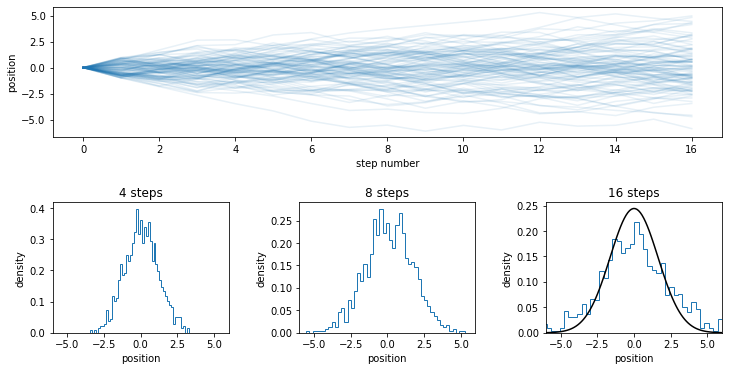

In [43]:
# Generate the numbers
x = (st.uniform.rvs(size=(1000, 16))-0.5)*2
# Make the plots
fig = plt.figure(figsize=(12, 6))
# Random walk illustration
ax1 = fig.add_subplot(211)
for steps in np.hstack([np.zeros((100, 1)), x[:100]]):
    plt.plot(np.cumsum(steps), color="C0", alpha=0.1)
ax1.set_xlabel("step number")
ax1.set_ylabel("position")
# Sequence of distributions
x = np.cumsum(x, axis=1)
for i, step in enumerate((4, 8, 16)):
    ax = fig.add_subplot(234+i)
    ax.hist(x[:,step-1], bins=50, density=True, histtype="step")
    ax.set_xlabel("position")
    ax.set_ylabel("density")
    ax.set_title(f"{step} steps")
    ax.set_xlim(left=-6, right=+6)
# Plot a gaussian approximation to the sum
var = (1/12)*(1-(-1)) # Variance of single uniform distribution
var *= 16 # Approx variance of sum of 16 iid uniforms
x = np.linspace(-6, 6, 100)
y = st.norm.pdf(x, scale=np.sqrt(var))
ax.plot(x, y, color="black")
plt.subplots_adjust(hspace=0.5, wspace=0.4)

### Code 4.2
Take the product of 12 random uniform numbers in the interval (1, 1.1)

In [145]:
np.prod(1 + 0.1*st.uniform.rvs(size=12))

1.8079947955267235

### Code 4.3
Now do the same thing 10,000 times and look at the distribution

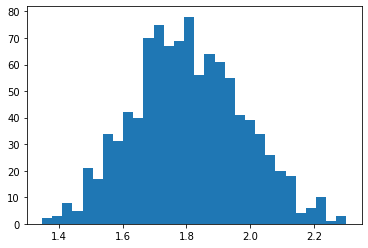

In [160]:
growth = np.prod(1 + 0.1*st.uniform.rvs(size=(1000, 12)), axis=1)
plt.hist(growth, bins=30)
plt.show()

### Code 4.4
Compare the effects of big and small multiplicative steps on convergence towards normality

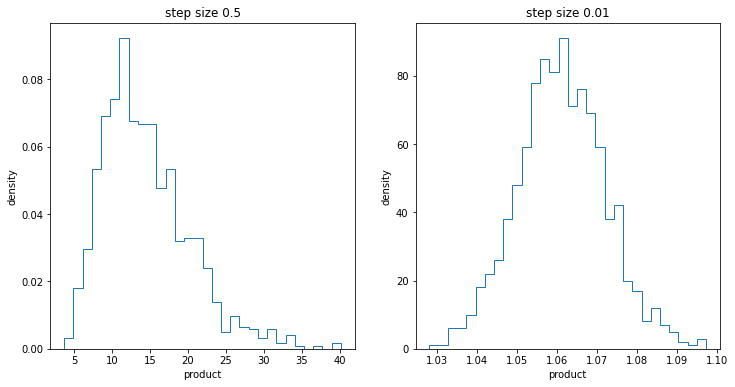

In [162]:
# Generate numbers
big = np.prod(1 + 0.5*st.uniform.rvs(size=(1000, 12)), axis=1)
small = np.prod(1 + 0.01*st.uniform.rvs(size=(1000, 12)), axis=1)
# Plot!
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
# Big
plt.sca(axes[0])
plt.hist(big, bins=30, histtype="step", density=True)
plt.xlabel("product")
plt.ylabel("density")
plt.title("step size 0.5")
# Small
plt.sca(axes[1])
plt.hist(small, bins=30, histtype="step")
plt.xlabel("product")
plt.ylabel("density")
plt.title("step size 0.01")
plt.show()

### Code 4.5
Multiplication is equivalent to addition on a log scale, i.e.
$$
\log\left(\prod_i x_i\right) = \sum_i \log(x_i)
$$

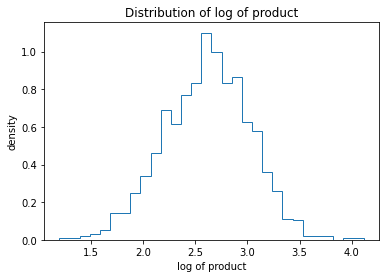

In [165]:
log_big = np.log(np.prod(1 + 0.5*st.uniform.rvs(size=(1000, 12)), axis=1))
plt.hist(log_big, bins=30, histtype="step", density=True)
plt.xlabel("log of product")
plt.ylabel("density")
plt.title("Distribution of log of product")
plt.show()

### Code 4.6
Redo the globe-tossing model for some reason?

In [168]:
w = 6; n = 9
p_grid = np.linspace(0, 1, 100)
posterior = st.binom(n=n, p=p_grid).pmf(6) * st.uniform.pdf(p_grid)
posterior /= posterior.sum()

### Code 4.7/4.8/4.9/4.10
Load some data on foraging populations conducted by Nancy Howell in the 1960's

In [174]:
howell_df = pd.read_csv("data/Howell1.csv", sep=";")
print("Number of rows:", len(howell_df))
howell_df.sample(6).T

Number of rows: 544


,43,109,185,145,60,179
height,147.32000,111.125000,142.875000,147.3200,155.575000,155.575000
weight,39.12231,17.123098,32.205032,36.8827,54.317642,42.099007
age,42.00000,11.000000,17.000000,22.0000,37.000000,26.000000
male,0.00000,1.000000,0.000000,0.0000,0.000000,0.000000


In [176]:
# Man, McElreath's `precis` function makes ascii histograms??!
howell_df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,544.0,138.263596,27.602448,53.975000,125.095000,148.590000,157.480000,179.070000
weight,544.0,35.610618,14.719178,4.252425,22.007717,40.057844,47.209005,62.992589
age,544.0,29.344393,20.746888,0.000000,12.000000,27.000000,43.000000,88.000000
male,544.0,0.472426,0.499699,0.000000,0.000000,0.000000,1.000000,1.000000


In [178]:
# This just accesses the 'height' column...
howell_df["height"];

### Code 4.11
Filter out only individuals younger than 18

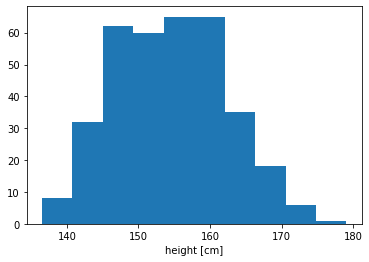

In [182]:
d2 = howell_df[howell_df["age"] >= 18]
plt.hist(d2["height"])
plt.xlabel("height [cm]")
plt.show()

### Code 4.12/4.13
Plot the priors for our height model,
$$
h_i \sim \text{Normal}(\mu, \sigma) \\
\mu \sim \text{Normal}(178, 20) \\
\sigma \sim \text{Uniform}(0, 50)
$$

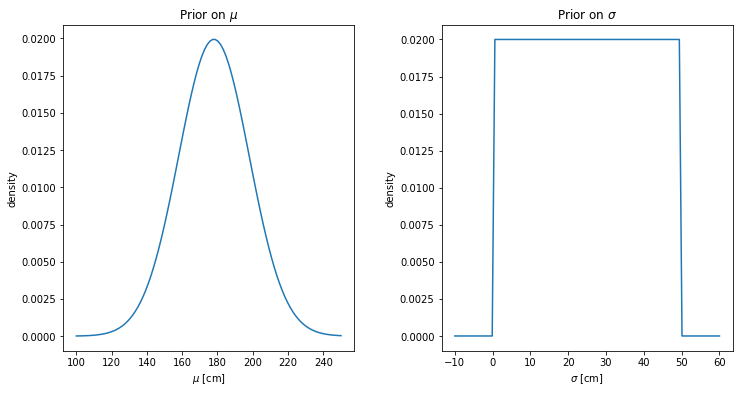

In [190]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
# mu prior
plt.sca(axes[0])
x = torch.linspace(100, 250)
y = Normal(178, 20).log_prob(x).exp()
plt.plot(x, y)
plt.title("Prior on $\mu$")
plt.xlabel("$\mu$ [cm]")
plt.ylabel("density")
# sigma prior
plt.sca(axes[1])
x = torch.linspace(-10, 60)
y = Uniform(0, 50).log_prob(x).exp()
plt.plot(x, y)
plt.title("Prior on $\sigma$")
plt.xlabel("$\sigma$ [cm]")
plt.ylabel("density")
plt.subplots_adjust(wspace=0.3)
plt.show()

### Code 4.14
Sample from the prior predictive for the $h_i$

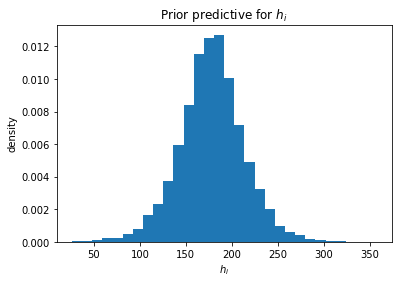

In [197]:
mu = Normal(178, 20).sample([10000])
sigma = Uniform(0, 50).sample([10000])
h = Normal(mu, sigma).sample()
plt.hist(h, bins=30, density=True)
plt.title("Prior predictive for $h_i$")
plt.xlabel("$h_i$")
plt.ylabel("density")
plt.show()

### Code 4.15
Observe the effect of a flatter prior for $\mu$ on the prior predictive for $h_i$

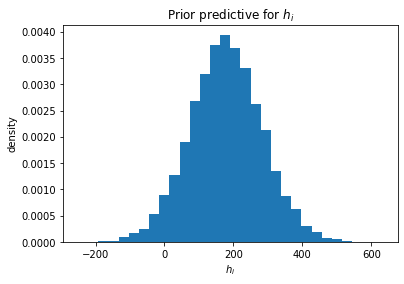

In [198]:
mu = Normal(178, 100).sample([10000])
sigma = Uniform(0, 50).sample([10000])
h = Normal(mu, sigma).sample()
plt.hist(h, bins=30, density=True)
plt.title("Prior predictive for $h_i$")
plt.xlabel("$h_i$")
plt.ylabel("density")
plt.show()

### Code 4.16
Use the grid approximation to calculate the posterior given the data

In [307]:
data = torch.tensor(d2["height"].values)
mu_grid = torch.linspace(150, 160, 100)
mu_prior = Normal(178, 20).log_prob(mu_grid).view(-1, 1)
sigma_grid = torch.linspace(7, 9, 100)
sigma_prior = Uniform(0, 50).log_prob(sigma_grid).view(1, -1)
posterior = (
    # Likelihood
    Normal(mu_grid.view(-1, 1, 1), sigma_grid.view(1, -1, 1)).log_prob(data).sum(axis=-1)
    # Priors
    + mu_prior + sigma_prior
)
posterior = torch.exp(posterior - posterior.max()) # Numerical trick to avoid overflow
posterior /= posterior.sum() # Normalize

### Code 4.17/4.18
Make a contour/heatmap plot of the posterior

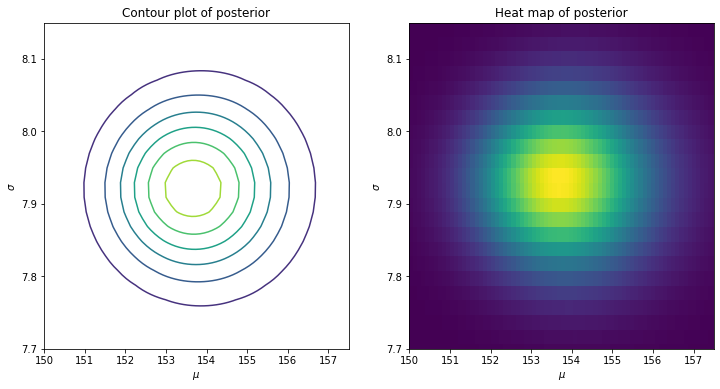

In [308]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
X, Y = np.meshgrid(mu_grid, sigma_grid)
plt.sca(axes[0])
plt.contour(X, Y, posterior)
plt.xlim(left=150, right=157.5)
plt.ylim(bottom=7.7, top=8.15)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Contour plot of posterior")
plt.sca(axes[1])
plt.pcolormesh(X, Y, posterior)
plt.xlim(left=150, right=157.5)
plt.ylim(bottom=7.7, top=8.15)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Heat map of posterior")
plt.show()

### Code 4.19/4.20
Sample from the posterior and plot the samples

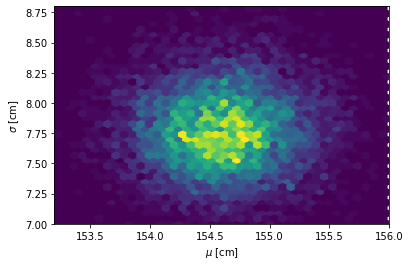

In [347]:
# The original grid was too coarse, so I'm gonna recompute on a smaller, finer grid
data = torch.tensor(d2["height"].values)
mu_grid = torch.linspace(153, 156, 500)
mu_prior = Normal(178, 20).log_prob(mu_grid).view(-1, 1)
sigma_grid = torch.linspace(7, 9, 500)
sigma_prior = Uniform(0, 50).log_prob(sigma_grid).view(1, -1)
posterior = (
    # Likelihood
    Normal(mu_grid.view(-1, 1, 1), sigma_grid.view(1, -1, 1)).log_prob(data).sum(axis=-1)
    # Priors
    + mu_prior + sigma_prior
)
posterior = torch.exp(posterior - posterior.max()) # Numerical trick to avoid overflow
posterior /= posterior.sum() # Normalize

# Sample from the posterior
idx = np.random.choice(np.prod(posterior.shape), p=posterior.flatten(), size=10000)
idx = np.vstack([idx//len(mu_grid), idx%len(mu_grid)])
samples = np.vstack((mu_grid[idx[0]], sigma_grid[idx[1]]))
plt.hexbin(*samples, gridsize=40)
# if you want to look at the scatter plot, though I don't think it's as useful:
# plt.scatter(*samples, s=0.5, alpha=0.1, color='red')
plt.xlim(left=153.2, right=156)
plt.ylim(bottom=7, top=8.8)
plt.xlabel("$\mu$ [cm]")
plt.ylabel("$\sigma$ [cm]")
plt.show()

### Code 4.21
Examine the marginal posterior densities of $\mu$ and $\sigma$

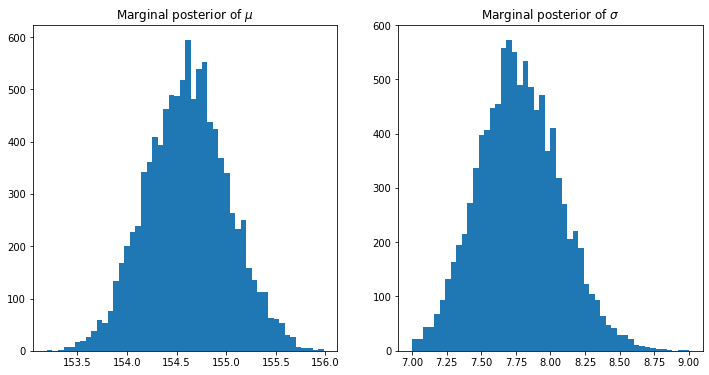

In [348]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
for i, label in enumerate(("mu", "sigma")):
    axes[i].hist(samples[i], bins=50)
    axes[i].set_title(f"Marginal posterior of $\{label}$")

### Code 4.22
Get the posterior credible intervals

In [365]:
print("mu CI:", HPDI(samples[0], 0.95))
print("sigma CI:", HPDI(samples[1], 0.95))

mu CI: (153.81163, 155.41684)
sigma CI: (7.208417, 8.35471)


### Code 4.23/4.24/4.25
Recalculate the posterior for using less data, and pay extra attention to the distribution in the $\sigma$ direction

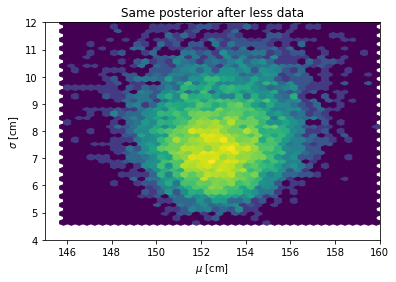

In [381]:
d3 = tt(d2["height"].sample(20).values)

mu_grid = torch.linspace(145, 160, 500)
mu_prior = Normal(178, 20).log_prob(mu_grid).view(-1, 1)
sigma_grid = torch.linspace(4, 12, 500)
sigma_prior = Uniform(0, 50).log_prob(sigma_grid).view(1, -1)
posterior = (
    # Likelihood
    Normal(mu_grid.view(-1, 1, 1), sigma_grid.view(1, -1, 1)).log_prob(d3).sum(axis=-1)
    # Priors
    + mu_prior + sigma_prior
)
posterior = torch.exp(posterior - posterior.max()) # Numerical trick to avoid overflow
posterior /= posterior.sum() # Normalize

# Sample from the posterior
idx = np.random.choice(np.prod(posterior.shape), p=posterior.flatten(), size=10000)
idx = np.vstack([idx//len(mu_grid), idx%len(mu_grid)])
samples = np.vstack((mu_grid[idx[0]], sigma_grid[idx[1]]))
plt.hexbin(*samples, gridsize=40, bins="log")
# if you want to look at the scatter plot, though I don't think it's as useful:
# plt.scatter(*samples, s=0.5, alpha=0.1, color='red')
plt.xlim(left=mu_grid[0], right=mu_grid[-1])
plt.ylim(bottom=sigma_grid[0], top=sigma_grid[-1])
plt.xlabel("$\mu$ [cm]")
plt.ylabel("$\sigma$ [cm]")
plt.title("Same posterior after less data")
plt.show()

Marginalize the posterior - note that sigma has a much heavier tail!

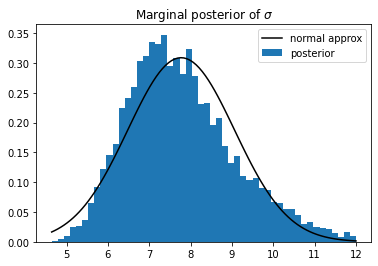

In [385]:
plt.hist(samples[1], bins=50, density=True, label="posterior")
mean = samples[1].mean()
std = samples[1].std()
x = np.linspace(samples[1].min(), samples[1].max(), 100)
y = st.norm(loc=mean, scale=std).pdf(x)
plt.plot(x, y, color='black', label="normal approx")
plt.title(f"Marginal posterior of $\sigma$")
plt.legend()
plt.show()

### Code 4.26/4.27/4.28/4.29
Compute the quadratic (Laplace) approximation to the posterior. There is no `quap` function available in python, so the first time I did this (in chapter 3?) I made the MAP estimate by hand, using gradient descent to find the posterior maximum, then got the second derivative at this location to estimate the standard deviation.

Now, I'm going to do it the `pyro` way. `pyro` has a handy class of objects called auto-guides which automatically construct a quick variational posterior for you to use with their Stochastic Variational Inference (SVI) algorithms. They conveniently have one called `AutoLaplaceApproximation`, which does the same thing a `quap`.

In [673]:
from pyro.infer.autoguide import AutoLaplaceApproximation, init_to_value
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import SGD

In [778]:
# Construct the dataset
d2 = tt(howell_df[howell_df["age"] >= 18]["height"].values)

# Specify the model
def model(data, train=True):
    mu = pyro.sample("mu", Normal(178, 20))
    sigma = pyro.sample("sigma", Uniform(0, 50))
    if train:
        with pyro.plate("obs", len(data)):
            pyro.sample("height", Normal(mu, sigma), obs=data)
    else:
        pyro.sample("height", Normal(mu, sigma))
            
# Specify the guide (using a handy Laplace approx.)
delta_guide = AutoLaplaceApproximation(
    model,
    init_to_value(values={"mu": d2.mean(), "sigma": d2.std()})
)

# Use SVI to get the MAP estimate
pyro.clear_param_store()
svi = SVI(model, delta_guide, optim=SGD({"lr": 1e-3}), loss=Trace_ELBO())
loss = [svi.step(d2) for _ in range(1000)]
# Expand around the posterior mode to get Laplace approx.
# AKA a multivariate normal
guide = delta_guide.laplace_approximation(d2)

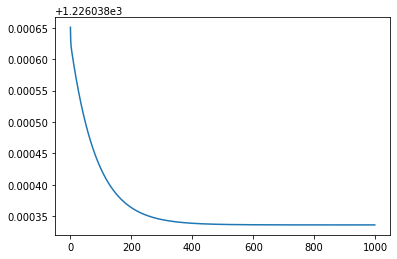

In [779]:
plt.plot(loss); plt.show()

In [780]:
# Here are the MAP estimates:
delta_guide()

{'mu': tensor(154.6070, dtype=torch.float64, grad_fn=<ExpandBackward>),
 'sigma': tensor(7.7403, dtype=torch.float64, grad_fn=<ExpandBackward>)}

In [781]:
# Sample from the posterior
samples = {
    k: v.flatten().detach().numpy()
    for k, v in Predictive(model, guide=guide, num_samples=10000)(d2, False).items()
}

In [782]:
# Ok, he calls this often enough that I'll make it into a function...
def precis(samples: dict, prob=0.89):
    """Computes some summary statistics"""
    p1, p2 = (1-prob)/2, 1-(1-prob)/2
    cols = ["mean","stddev",f"{100*p1:.1f}%",f"{100*p2:.1f}%"]
    df = pd.DataFrame(columns=cols, index=samples.keys())
    for k, v in samples.items():
        df.loc[k]["mean"] = v.mean()
        df.loc[k]["stddev"] = v.std()
        q1, q2 = np.quantile(v, [p1, p2])
        df.loc[k][f"{100*p1:.1f}%"] = q1
        df.loc[k][f"{100*p2:.1f}%"] = q2
    return df

In [783]:
precis(samples)

,mean,stddev,5.5%,94.5%
mu,154.614,0.412641,153.96,155.28
sigma,7.74389,0.292151,7.29293,8.2231
height,154.664,7.75594,142.338,167.158


### Code 4.30
It is usually a good idea to give smart starting values when trying to find the MAP estimate. A good choice for $\mu$ and $\sigma$ are the sample mean and standard deviation of the height data. We already did this when initializing the guide in the above pyro model, but here's the values they would take:

In [784]:
print("initial mu:", d2.mean().item())
print("initial sigma:", d2.std().item())

initial mu: 154.5970926136364
initial sigma: 7.742332137351996


We can see they're already pretty close to the MAP values, which is good!

### Code 4.31
Redo the thing but with a much narrower prior on $\mu$ just to see what happens

In [785]:
# Construct the dataset
d2 = tt(howell_df[howell_df["age"] >= 18]["height"].values)

# Specify the model
def model(data, train=True):
    mu = pyro.sample("mu", Normal(178, 0.1))
    sigma = pyro.sample("sigma", Uniform(0, 50))
    if train:
        with pyro.plate("obs", len(data)):
            pyro.sample("height", Normal(mu, sigma), obs=data)
    else:
        pyro.sample("height", Normal(mu, sigma))
            
# Specify the guide (using a handy Laplace approx.)
delta_guide = AutoLaplaceApproximation(
    model,
    init_to_value(values={"mu": d2.mean(), "sigma": d2.std()})
)

# Use SVI to get the MAP estimate
pyro.clear_param_store()
svi = SVI(model, delta_guide, optim=SGD({"lr": 1e-3}), loss=Trace_ELBO())
loss = [svi.step(d2) for _ in range(100)]
    
# Expand around the posterior mode to get Laplace approx.
# AKA a multivariate normal
guide = delta_guide.laplace_approximation(d2)

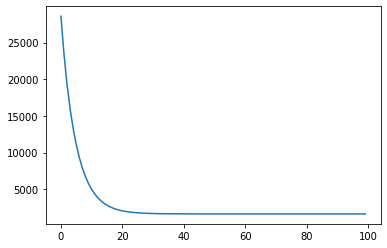

In [786]:
# Plot the loss
plt.plot(loss); plt.show()

We can see that the prior has very strongly affected the posterior - the MAP estimate is much closer to the mean of the prior than to the mean of the posterior, and the estimate for $\sigma$ is also much larger.

In [787]:
delta_guide()

{'mu': tensor(177.8630, dtype=torch.float64, grad_fn=<ExpandBackward>),
 'sigma': tensor(24.5174, dtype=torch.float64, grad_fn=<ExpandBackward>)}

In [788]:
# Sample from the posterior
samples_ = {
    k: v.flatten().detach().numpy()
    for k, v in Predictive(model, guide=guide, num_samples=10000)(d2, False).items()
}
precis(samples_)

,mean,stddev,5.5%,94.5%
mu,177.864,0.0989414,177.707,178.021
sigma,24.5169,0.933515,23.0218,26.0036
height,178.175,24.2565,139.334,216.789


### Code 4.32
Calculate the covariance of the posterior variables

In [794]:
np.cov([samples["mu"], samples["sigma"]])

array([[ 0.17028926, -0.00139587],
       [-0.00139587,  0.08536052]])

### Code 4.33
Decompose the covariance into the variance vector and the correlation matrix. Recall that the covariance matrix is defined by
$$
\text{cov}(X_i, X_j) = \Sigma_{ij} = \frac{1}{N} \sum_{k=1}^N (\bar{x}_i - x_k) (\bar{x}_j - x_k)
$$
and the (Pearson) correlation coefficient by
$$
r(X_i, X_j) = \frac{\text{cov}(X_i, X_j)}{\sigma_i \sigma_j}
$$

In [808]:
cov = np.cov([samples["mu"], samples["sigma"]])
r = np.corrcoef([samples["mu"], samples["sigma"]]) # easier to use built-in functions
print("variance vector:\n", np.diag(cov))
print("correlation matrix:\n", r)

variance vector:
 [0.17028926 0.08536052]
correlation matrix:
 [[ 1.         -0.01157772]
 [-0.01157772  1.        ]]


### Code 4.34/4.35
Sample from the posterior... already done

In [810]:
pd.DataFrame(samples).head()

,mu,sigma,height
0,154.837234,8.153624,169.101133
1,153.886213,7.471368,157.159583
2,154.415502,8.055084,153.253094
3,153.952895,8.538124,144.168340
4,154.261885,7.841463,135.305793


In [811]:
precis(samples)

,mean,stddev,5.5%,94.5%
mu,154.614,0.412641,153.96,155.28
sigma,7.74389,0.292151,7.29293,8.2231
height,154.664,7.75594,142.338,167.158


### Code 4.36
Sample directly from a multivariate normal with the same parameters as the Laplace approx.

In [812]:
from pyro.distributions import MultivariateNormal

In [831]:
samples_ = tt(np.vstack([samples["mu"], samples["sigma"]]).T).float()
samples_ = MultivariateNormal(
    loc=samples_.mean(axis=0),
    covariance_matrix=tt(np.cov(samples_.T)).float()
).sample([10_000]).numpy()

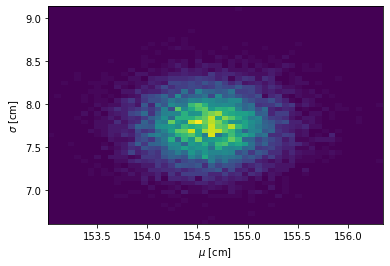

In [844]:
plt.hist2d(*samples_.T, bins=50)
plt.xlabel("$\mu$ [cm]")
plt.ylabel("$\sigma$ [cm]")
plt.show()

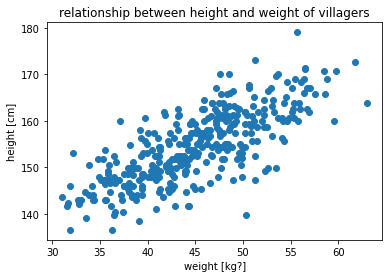

In [849]:
d2 = howell_df[howell_df["age"] >= 18]
plt.scatter(d2["weight"], d2["height"])
plt.xlabel("weight [kg?]")
plt.ylabel("height [cm]")
plt.title("relationship between height and weight of villagers")
plt.show()

### Code 4.38/4.39
Draw some samples from the prior and plot the resulting regression lines (I'll detail the model a couple cells after this)

In [883]:
N = 100
a = st.norm(loc=178, scale=20).rvs(N)
b = st.norm(loc=0, scale=10).rvs(N)

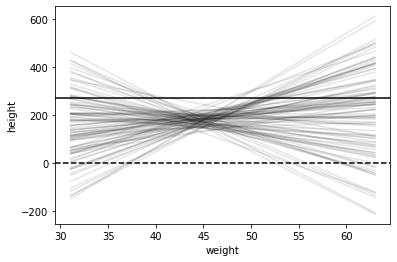

In [884]:
x = np.linspace(d2["weight"].min(), d2["weight"].max())
xbar = d2["weight"].mean()
for i in range(N):
    plt.plot(x, a[i] + b[i]*(x - xbar), color="black", alpha=0.1)
plt.axhline(272, color="black")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("weight")
plt.ylabel("height")
plt.show()

The solid horizontal line is the world's tallest person, and the dashed horizontal line is a height of zero. Heights below zero are impossible, and heights above the world record are _incredibly_ unlikely. Is this really a good prior?

### Code 4.40
We can get a better prior by using a log-normal distribution for $\beta$ instead of a normal. Let's take a look at what one looks like:

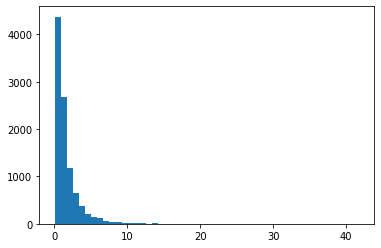

In [888]:
# if mu, sigma are the parameters for a normal distribution X, then
# the lognormal distribution Y = log(X) is parametrized by scale=exp(mu)
# and s=sigma (at least in scipy)
b = st.lognorm(scale=np.exp(0), s=1).rvs(10000)
plt.hist(b, bins=50)
plt.show()

In [866]:
from pyro.distributions import LogNormal

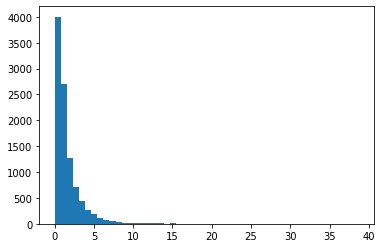

In [875]:
# in pyro, loc=mu and scale=sigma of the underlying
# normal distribution, quite contradictory to the way
# they're defined in scipy! just goes to show you
# should _always_ read the documentation before
# attempting to use any math-heavy libraries as
# different conventions for common things abound!
b = LogNormal(loc=0, scale=1).sample([10000])
plt.hist(b, bins=50)
plt.show()

### Code 4.41
Recreate the plot from 4.39, but with this log-normal prior on $\beta$

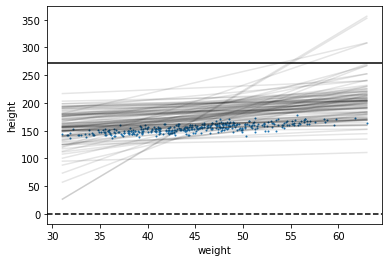

In [889]:
# Sample from new prior
N = 100
a = st.norm(loc=178, scale=20).rvs(N)
b = st.lognorm(scale=np.exp(0), s=1).rvs(N)

# Plot regression lines from the prior
x = np.linspace(d2["weight"].min(), d2["weight"].max())
xbar = d2["weight"].mean()
for i in range(N):
    plt.plot(x, a[i] + b[i]*(x - xbar), color="black", alpha=0.1)
plt.axhline(272, color="black")
plt.axhline(0, color="black", linestyle="--")

# Plot the data too for comparison
plt.scatter(d2["weight"], d2["height"], s=1)
plt.xlabel("weight")
plt.ylabel("height")
plt.show()

This looks much more sensible; even though it seems that the tail of $\beta$ puts a bit too much emphasis on large slopes.

### Code 4.42
Build the linear regression model and get the quadratic posterior approximation. The model is given by

$$
\begin{align}
h_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta(x_i + \bar{x}) \\
\alpha &\sim \text{Normal}(178, 20) \\
\beta &\sim \text{Log-Normal}(0, 1) \\
\sigma &\sim \text{Uniform}(0, 50)
\end{align}
$$

In [907]:
# Format data
weight = tt(d2["weight"].values).float()
height = tt(d2["height"].values).float()

In [920]:
# Create model/guide
def model(weight, height=None):
    alpha = pyro.sample("alpha", Normal(178, 20))
    beta = pyro.sample("beta", LogNormal(0, 1))
    sigma = pyro.sample("sigma", Uniform(0, 50))
    mu = alpha + beta * (weight - weight.mean())
    if height is None:
        return pyro.sample("height", Normal(mu, sigma))
    else:
        pyro.sample("height", Normal(mu, sigma), obs=height)
    
delta_guide = AutoLaplaceApproximation(
    model,
    init_to_value(values={
        "alpha": height.mean(),
        "sigma": height.std(),
    })
)

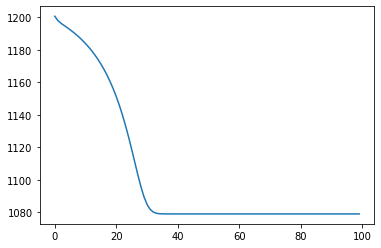

In [921]:
# Perform inference
svi = SVI(model, delta_guide, optim=SGD({"lr": 1e-3}), loss=Trace_ELBO())
pyro.clear_param_store()
loss = [svi.step(weight, height) for _ in range(100)]
guide = delta_guide.laplace_approximation(weight, height)
plt.plot(loss)
plt.show()

In [922]:
# MAP estimate
delta_guide()

{'alpha': tensor(154.6003, grad_fn=<ExpandBackward>),
 'beta': tensor(0.9052, grad_fn=<ExpandBackward>),
 'sigma': tensor(5.0783, grad_fn=<ExpandBackward>)}

### Code 4.43
Make the same model, but use $\log(\beta)$ as a parameter rather than $\beta$ itself

In [931]:
# This is just for illustration, I won't actually evaluate this
# def model(weight, height=None):
#     alpha = pyro.sample("alpha", Normal(178, 20))
#     log_beta = pyro.sample("log_beta", Normal(0, 1))
#     sigma = pyro.sample("sigma", Uniform(0, 50))
#     mu = alpha + torch.exp(log_beta) * (weight - weight.mean())
#     if height is None:
#         return pyro.sample("height", Normal(mu, sigma))
#     else:
#         pyro.sample("height", Normal(mu, sigma), obs=height)